This notebook is going to contain my work so far on modeling 1-D Guassians with various MCMC tools in python. The goal of this project is to eventually move to processing of fits image data. Specfically (at least for the time being) the specific goal will be to fit to 1 galaxy with a Mixture of Gaussians model, rather than fidning several in an image. One of the central complications in this is that the number of Gaussians, $N$, also controls the length of the parameter vector  $\Theta$. This creates some algorithmic complications I haven't yet figured out how to get around. Therefore, I'm attempting to solve the problem in 1-D first, using different MCMC tools to see which works best. Below I'm going to generate some pseudo-random data to fit to.

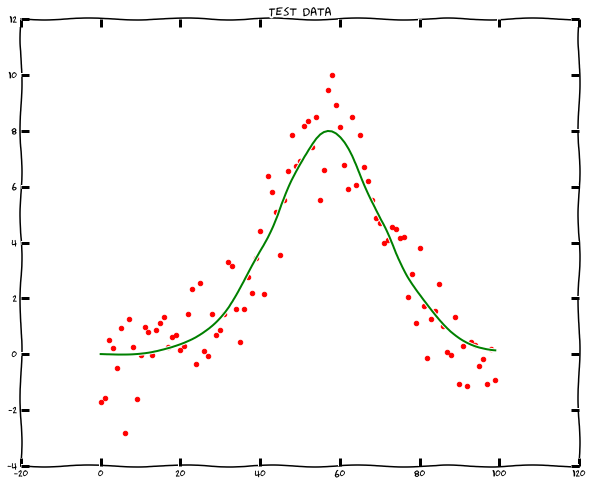

In [1]:
import numpy as np

SIZE = 100 #length of data array
N = 3 #number of Gaussians in the data

#Deterministic. Seed with int(time.time()) for genuine randomness.
np.random.seed(1) 

def gaussian(x,center, width, amplitude):
#my model of a gaussian
    return amplitude*np.exp(-.5*pow((x-center)/width,2))

#All the Gaussians have the same center
true_center = np.random.randint(SIZE/5, (SIZE*4)/5+1)
true_widths = np.asarray([np.random.rand()*10+5 for n in xrange(N)])
true_amps = np.asarray([np.random.randint(1,10) for n in xrange(N)])

x = np.arange(SIZE) 
orig_data = np.zeros(SIZE)
for w, a in zip(true_widths, true_amps):
    orig_data+=gaussian(x, true_center, w, a)
    
#Add some noise
NOISE_LEVEL = .4*true_amps.mean()
data=orig_data + np.random.normal(size=SIZE)*NOISE_LEVEL

from matplotlib import pyplot as plt
plt.xkcd()
from IPython.core.pylabtools import figsize
%matplotlib inline
figsize(10,8)

plt.scatter(x,data, color = 'r', label = '$Data$')
plt.plot(x, orig_data, color = 'g', label ='$Noiseless Data$')
plt.title("Test Data")

###pyMC

The first tool I attempted to use was pyMC. pyMC has a great library of builtins to use, and the model construction is pretty fluid. Unfortunately it can also a little bit restrictive with certain things. 

I won't go into too much detail on the layout of the model because it's fairly self explanatory. 

In [10]:
import pymc as pm

#Take a uniform prior on the center of the peak
#first guess is the center of the 'image'
center = pm.Uniform('center', 0 ,SIZE, value = SIZE/2.0)

#take a chi2 prior for the widths
#the degree of freedom is chosen such that the peak is where we believe the widths to most likely be.
#The size keyword creates N Chi2 variables in one place
widths = pm.Chi2('widths', 7, size = N)

#Uniform prior for N amplitudes
amps = pm.Uniform('amps', 1, 10, value = [5 for i in xrange(N)], size = N)

#deterministic variables require this decorator
@pm.deterministic
def pm_gaussian(x = x, center = center, widths = widths, amps = amps):
    #pyMC does some behind the scenes work turning their objects to numpy variables
    return sum(gaussian(x, center, w, a) for w,a in zip(widths, amps))

#this variable corresponds to the noise in the data
tau = pm.Chi2('tau', 4)

#connect our model to the data
pm_data = pm.Normal('pm_data', pm_gaussian, tau, value = data, observed = True)

model = pm.Model([pm_data, tau, pm_gaussian, amps, widths, center])

#pyMC can perform a fit to make convergence faster. 
map_ = pm.MAP(model)
map_.fit()

mcmc_g = pm.MCMC(model)

mcmc_g.sample(10**4, burn = 2000, thin = 2)

 [-----------------100%-----------------] 10000 of 10000 complete in 10.2 sec

True Center: 57	Calc Center: 56.884751

True Widths: [ 14.97184811  14.32557359   6.28124448]
Calc Widths: [12.958945050071859, 11.861028119609143, 12.923855766585428]

True Amps: [6 1 1]
Calc Amps:[2.9926426425625223, 2.5977484728404896, 2.8194518647493001]


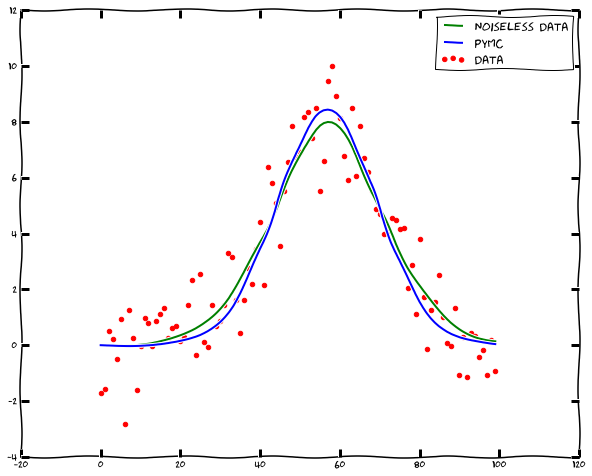

In [11]:
#Now lets so it did.
pm_widths = []
pm_amps = []

center_trace = mcmc_g.trace('center')[:]
pm_center = center_trace.mean() #scipy.stats.mode can also be used
width_trace = mcmc_g.trace('widths')[:]
amp_trace = mcmc_g.trace('amps')[:]

for n in xrange(N):
    pm_widths.append((width_trace[:,n]).mean())
    pm_amps.append((amp_trace[:,n]).mean())
    
print "True Center: %d\tCalc Center: %f\n"%(true_center, pm_center)
print "True Widths: " + str(true_widths)
print "Calc Widths: " + str(pm_widths)
print
print "True Amps: " + str(true_amps)
print "Calc Amps:" + str(pm_amps)
    
plt.scatter(x,data, color = 'r', label = "Data")
plt.plot(x, orig_data, color = 'g', label = 'Noiseless Data')
plt.plot(x, sum(gaussian(x, pm_center, w,a) for w,a in zip(pm_widths, pm_amps)), color = 'b', label = 'pyMC')
plt.legend()

A few things to take away from this. Firstly, the fit is a decent fit to the data, but not a great match. I do not know if it could be considered "acceptable". It definetly does not recover the original parameters, but is seems to compensate for it. pyMC also incorporates a plotting feature that plots the taces of the different variables. Let's take a look at that, too. 

From this it's clear that the center converges pretty quickly, but width and amplitude don't very well. The black bar on the histogram represents the mean, and the gray dashed lines are the 95% confidence interval. So, pyMC really has no clue what they should be. It's possible that a longer sample could improve convergence, but I'm not sure. The central problem, I think, is that there's a lot of coupling between parameters. The amplitudes can't converge to one value because they are dependant on one another, same with the widths.

I do not know how to do a variable number of gaussians with this package. The `size` parameter in pyMC's stochastic variables does not take anything other than an integer as arguement. This package also becomes more challenging to use in 2-D, since pyMC seems focused on 1-D analysis. 

###emcee Hammer

Next I'm going to work with the emcee package. The emcee package offfers a lot more control than pyMC, but that also means a little bit more work. It also has a few performance advantages, like built-in multiprocessing. Let's start.

In [18]:
import emcee as mc

#in emcee you either get to or have to define your own posterior, depending on how you look at it
#I do so below

def lnprior(theta): 
#the log prior for the distribution
#I use primarily uniform distributions, but others are possible.
#theta contains all the parameters for the fit.
#It will be of the form [center, width1, width2,... widthN,amp1,...ampN]
    center = theta[0]
    widths = theta[1:N+1]
    amps = theta[N+1:]
    #all values must be >0
    if any(t<0 for t in theta):
        return -np.inf #ln(0) = -Infinity
    #amps must be >1
    if any(a<1 for a in amps):
        return -np.inf
    #each variable has an upper limit
    if center>SIZE or any(w>20 for w in widths) or any(a>12 for a in amps):
        return -np.inf
    #TODO Chi2 for sigma here
    return 0 #log(1) = 0

def lnlike(theta,x, y, err):
#the log likeliklihood for the distribution
#I use a gaussian form for the noise
    center = theta[0]

    t = []
    for n in xrange(N):
        t.append((theta[1+n],theta[1+n+N]))
        
    model = np.zeros(SIZE)
    for w, a in t:
        model+=gaussian(x,center, w,a)
        
    inv_sigma2 = 1./(err**2)# the noise of the data
    
    #log of the gaussian
    return -.5*(np.sum(((y-model)**2)*inv_sigma2-np.log(inv_sigma2)))

def lnprob(theta, x, y, err):
#combined posterior probability
    lp = lnprior(theta)
    if np.isfinite(lp):
        return lp+ lnlike(theta, x, y, err)
    return -np.inf

Now that the priors have been defined, I'll begin the sampler. 

In [19]:
#emcee uses a different sampling algorithm the standard Metropolis-Hastings, the Affine Invariant MCMC Ensemble Sampler
#It employs the use of 100's of walkers that step through the space in paraellel.

nwalkers = 500
ndim = N*2+1 #amp and width for each Gaussian, plus center

nburn = 100
nsteps = 200

true_err = .01#make a guess for the error. Isn't terribly important.

#get the number of cpus to run in parallel
from multiprocessing import cpu_count
ncores = cpu_count()

#create a starting guess
pos = []
for walk in xrange(nwalkers):
    row = np.zeros(ndim)
    row[0] = (2+np.random.rand())*.2*SIZE
    for n in xrange(N):
        row[1+n] = 5+10*np.random.rand()
        row[N+n+1] = np.random.randint(1,10)
    pos.append(row)
    
#create the sampler object and run
sampler = mc.EnsembleSampler(nwalkers, ndim, lnprob, args =(x,data, true_err), threads = ncores)
#this may take a few seconds
sampler.run_mcmc(pos, nsteps)
samples = sampler.chain[:, nburn:, :].reshape((-1, ndim))

Now plot.

True Center: 57	Calc Center: 56.802608

True Widths: [ 14.97184811  14.32557359   6.28124448]
Calc Widths: [ 13.25675808  12.2684216   12.88143655]

True Amps: [6 1 1]
Calc Amps:[ 3.3357265   2.67650762  2.68029965]


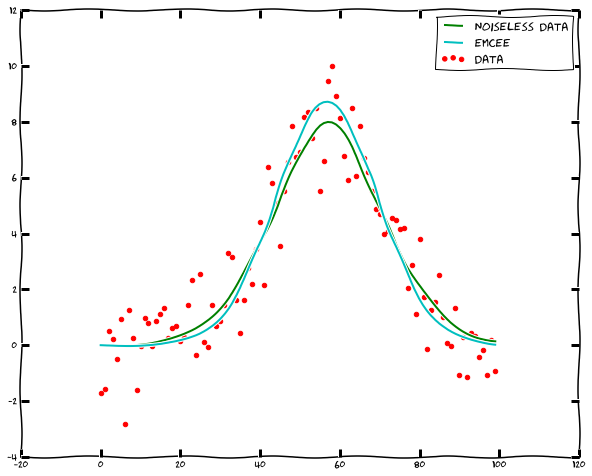

In [20]:
means = samples.mean(axis = 0)
mc_center = means[0]
mc_widths = means[1:N+1]
mc_amps = means[N+1:]

print "True Center: %d\tCalc Center: %f\n"%(true_center, mc_center)
print "True Widths: " + str(true_widths)
print "Calc Widths: " + str(mc_widths)
print
print "True Amps: " + str(true_amps)
print "Calc Amps:" + str(mc_amps)

plt.scatter(x,data, color = 'r', label = "Data")
plt.plot(x, orig_data, color = 'g', label = 'Noiseless Data')
#uncomment to see alongside pyMC
#plt.plot(x, sum(gaussian(x, pm_center, w,a) for w,a in zip(pm_widths, pm_amps)), color = 'b', label = 'pyMC')
plt.plot(x, sum(gaussian(x, mc_center, w,a) for w,a in zip(mc_widths, mc_amps)), color = 'c', label = 'emcee')
plt.legend()

Pretty good, and made almost the same mistakes that pyMC with overestimating the peak. Once again it also didn't recover the parameters but the visual fit is still quite good. 

If you want to install triangle_plot, it also provides a great visualization for MCMC traces, which I will employ here to show how this converged. To install just run:

`$ pip install triangle_plot`

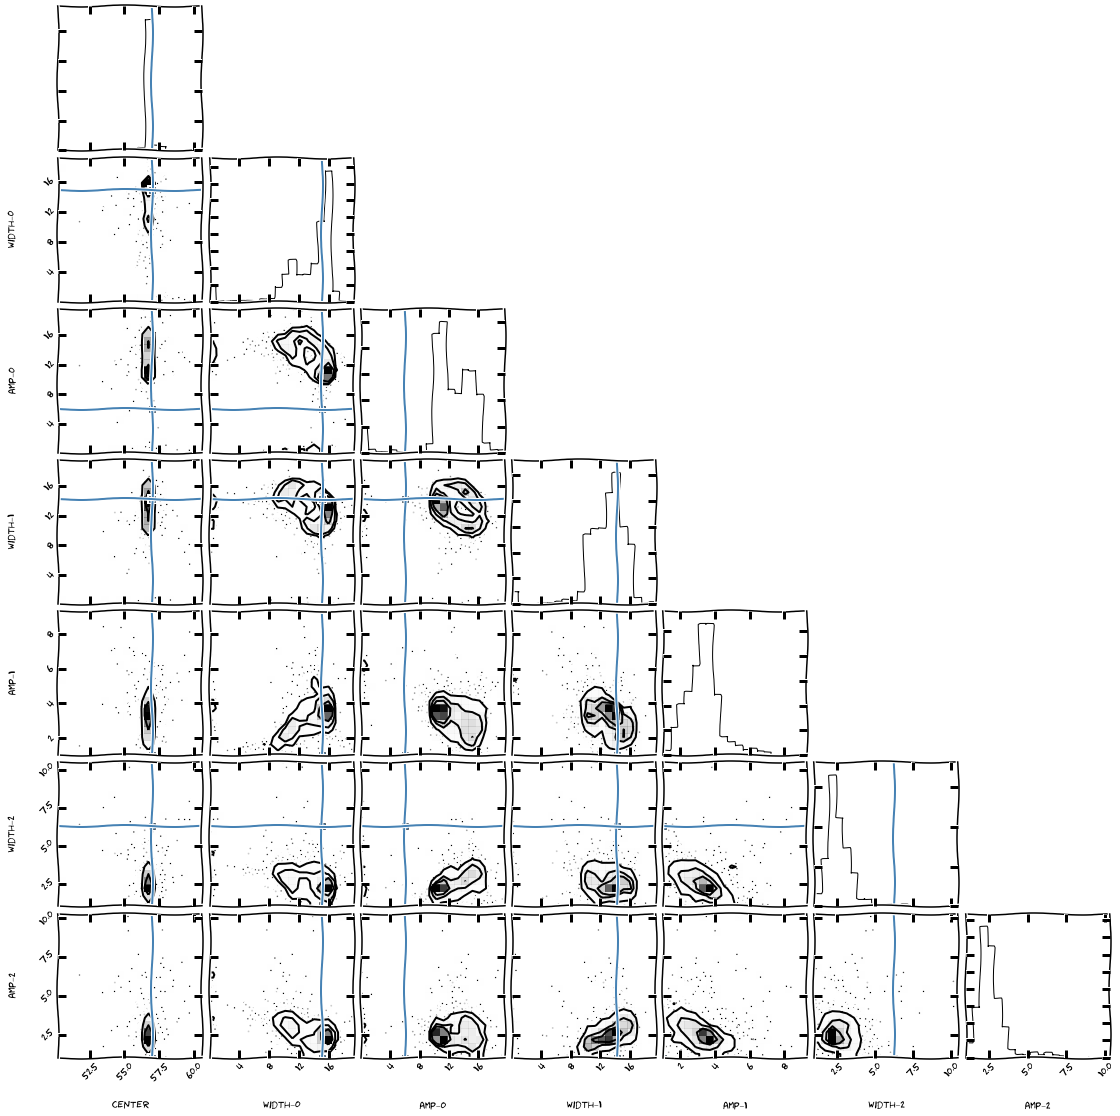

In [21]:
from triangle import corner
labels = ['center']
truths = [true_center]
for n in xrange(N):
    labels.append('width_%d'%n)
    truths.append(true_widths[n])
    
    labels.append('amp_%d'%n)
    truths.append(true_amps[n])
    
fig = corner(samples,labels = labels, truths = truths )
plt.show()

For this many of Gaussians this plot has a bit of an overwhelming amount of information. The blue lines indicate the "true" values, which is most of what you need to know to get the gist of these plots. Once again the centers converge no problem, but the widths and amplitudes struggle. 

###Multinest
I actually haven't implemented this before here, so I'll be doing it live here in the notebook. For that reason it might be pretty sketchy/bad. 

In [10]:
import json
import pymultinest
#NOTE : This will crash is libmultinest.so is not in yoru LD_LIBRARY_PATH.
#Let me know if for some reason that isnt working. 

true_err = .01
def mn_prior(theta, ndim, nparams):
#theta is of the form [center, width1, width2,...widthN, amp1...ampN]
#this prior works differently, by filling theta with uniform [0,1]
#I now have to transform to our proper prior space
    theta[0] = .2*SIZE*(2+ theta[0]) 
    for i in xrange(1, N+1):
        theta[i] = theta[i]*25+1
        theta[i+N] = theta[i+N]*9+1
    
def loglike(theta, ndim, nparams):
    center = theta[0]
    widths = theta[1:N+1]
    amps = theta[N+1:nparams]
    model = sum(gaussian(x, center, w,a) for w,a in zip(widths, amps))
    inv_sigma2 = 1/(true_err**2)
    return -.5*(np.sum(((data-model)**2)*inv_sigma2-np.log(inv_sigma2)))
 
parameters = ['center']
for n in xrange(N):
    parameters.append('width_%d'%n)
for n in xrange(N):
    parameters.append('amp_%d'%n)
    
n_params = len(parameters) 
base_filename = 'sean_multinest_out' # i reccomend changing this. 

In [11]:
pymultinest.run(loglike, mn_prior, n_params, outputfiles_basename = base_filename, resume = False, verbose = True)

And now plot.

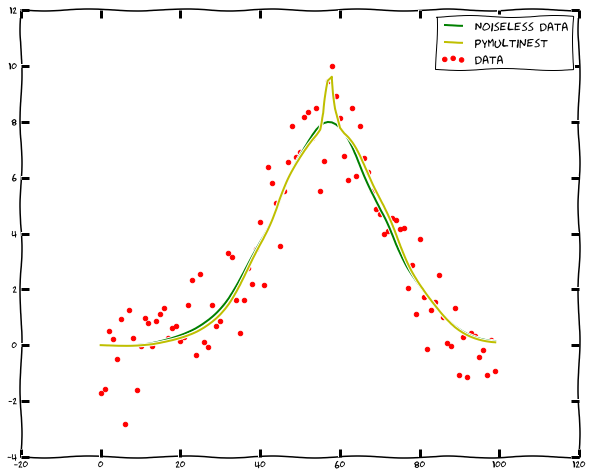

In [12]:
fit_image = np.zeros(SIZE)

mn_data = np.loadtxt(base_filename+'post_equal_weights.dat')
means = mn_data.mean(axis = 0)

mn_center = means[0]
mn_widths = []
mn_amps = []
for n in xrange(N):
    mn_widths.append(means[1+n])
    mn_amps.append(means[1+n+N])

plt.scatter(x,data, color = 'r', label = "Data")
plt.plot(x, orig_data, color = 'g', label = 'Noiseless Data')
plt.plot(x, sum(gaussian(x, mn_center, w,a) for w,a in zip(mn_widths, mn_amps)), color = 'y', label = 'pymultinest')
plt.legend()
plt.savefig('/home/jeffrey/my_notebooks/multinest.png') 

Wow that worked extremely well except for that weird peak in the middle there. 

So yeah that's what I've got so far, for 1-D stuff. 